In [1]:
from pathlib import Path
import json

import numpy as np

import geopandas as gpd

import wandb

import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR


from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import segmentation_models_pytorch as smp

from src.dataset_preload import Dataset
from src.unet_pl import LightningModel
from src.losses import tanimoto_loss
from src.tools import show_samples
from src.tools import Rot90Flips
from src.tools import training_loop
from src.tools import validate_test
from src.tools import get_rpg_patches
from src.tools import get_ai4s_patches
from src.tools import get_AdamWMultiStep
from src.tools import get_AdamWOneCycle

from torch.optim.lr_scheduler import OneCycleLR

from src.losses import DiceLoss

# Data

In [2]:
def get_datasets(image_paths, mask_paths, mask_band, min_max, data_augmentations=None):
    print('Loading datasets')

    train_dataset = Dataset(
        image_paths['train'],
        mask_paths['train'], 
        mask_band = mask_band,
        augmentation=data_augmentations,
        normalize=min_max,
    )

    valid_dataset = Dataset(
        image_paths['validate'],
        mask_paths['validate'], 
        mask_band = mask_band,
        normalize=min_max,
    )

    test_dataset = Dataset(
        image_paths['test'],
        mask_paths['test'], 
        mask_band = mask_band,
        normalize=min_max,
    )

    print(f"Train size: {len(train_dataset)}")
    print(f"Valid size: {len(valid_dataset)}")
    print(f"Test size: {len(test_dataset)}")
    return train_dataset, valid_dataset, test_dataset

def get_loaders(train_dataset, valid_dataset, test_dataset, batch_size, n_cpu):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)
    return train_dataloader, valid_dataloader, test_dataloader

# Model

## Adapting model with optimizer and scheduler

In [3]:
AdamWMultiStep = get_AdamWMultiStep(LightningModel, milestones=[20,40,60,80], gamma = 0.3)
AdamWOneCycle = get_AdamWOneCycle(LightningModel)

'\nclass AdamWMultiStep(LightningModel):\n    def  configure_optimizers(self):\n        optimizer = torch.optim.AdamW(\n            self.parameters(),\n            lr=self.hparams.lr,\n        )\n        scheduler_dict = {\n            "scheduler": MultiStepLR(optimizer, milestones=[20,40,60,80], gamma=0.3),\n            "interval": "step",\n        }\n        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}\n\nclass AdamWOneCycle(LightningModel):\n    def configure_optimizers(self):\n        optimizer = torch.optim.AdamW(\n            self.parameters(),\n            lr=self.hparams.lr,\n        )\n        scheduler_dict = {\n            "scheduler": OneCycleLR(\n                optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader)\n            ),\n            "interval": "step",\n        }\n        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}\n\n'

# Training End

In [4]:
def send_images(model, logger, test_dataloader):
    batch = next(iter(test_dataloader))
    with torch.no_grad():
        model.eval()
        logits = model(batch["image"])
    pr_masks = (logits.sigmoid() > 0.5).float().numpy()

    nb_samples = 25
    x,y = batch['image'][:nb_samples].numpy(), batch['mask'][:nb_samples].numpy()
    x = x[:,:3].transpose(0,2,3,1)
    ids = batch['id'][:nb_samples]
    columns = ['image', 'ground truth', 'prediction', 'id']
    data = [[wandb.Image(x_i), wandb.Image(y_i), wandb.Image(y_pred), id] for x_i, y_i, y_pred, id in zip(x, y, pr_masks, ids)]
    logger.log_table(
        key='test_samples',
        columns=columns,
        data=data) 
    
    wandb.finish()

# Configuration

## Datasets

In [5]:
# mask_bands for DS_RPG_SPOT
mask_bands_rpg = {
              'Extent':0, 
              #'Instance (ID_PARCEL)':1,
              #'Instance (SUPER_GROU)':2,
              'Border (ID_PARCEL)':3,
              #'Border (SUPER_GROU)':4, 
              'Interior (ID_PARCEL)':5,
              #'Interior (SUPER_GROU)':6
}

# mask_bands for AI4SmallFarms
mask_bands_ai4s = {
              'Extent':0, 
              'Border':2
              }


# test datasets are smaller to allow for fast runs to check everything works
dataset_configs = {
                'RPG':  get_rpg_patches('../patches/') | {'bands': mask_bands_rpg},
                 'AI4S': get_ai4s_patches('../ai4smallfarms/patches/') | {'bands': mask_bands_ai4s},
                 'RPG_test':  get_rpg_patches('../patches/', sample=200) | {'bands': mask_bands_rpg},
                 'AI4S_test':  get_ai4s_patches('../ai4smallfarms/patches/', sample=200) | {'bands': mask_bands_ai4s},
                 }


## Static

In [6]:
data_aug = True
data_augmentations = Rot90Flips() if data_aug else None


# this is where the project will be logged on wandb
project_name = 'unet_rpg_scrap'

# number of CPU cores used for the dataloaders
n_cpu = 10

batch_size = 32
max_epochs = 2
lr = 0.001

opti_name = 'AdamW'
scheduler_name = 'MultiStepLR'
scheduler_name = 'MultiStepLR'

labels = ['image', 'mask']

dataset_choice = 'RPG_test'
config = dataset_configs[dataset_choice]
paths = config['paths']
min_max = config['min_max']
mask_bands = config['bands']


## Choices

In [7]:
losses = { 
        'Dice': DiceLoss(),
          #'Tanimoto':tanimoto_loss, 
          }

In [8]:
hyperparameters = {
    'data_aug':data_aug, 
    'batch_size':batch_size, 
    'optimizer':opti_name, 'lr_scheduler':scheduler_name,
    'task':None,
    'loss':None
}

def get_callbacks():
    early_stopping = EarlyStopping(monitor='valid_iou', patience=50, mode='max')
    model_checkpoint = ModelCheckpoint(monitor='valid_iou', mode='max', save_top_k=1)
    callbacks = [early_stopping, model_checkpoint]
    return callbacks

# One Model

## Making choices

In [10]:
task = 'Extent'
mask_band = mask_bands[task]
hyperparameters['task'] = task

loss_name = 'Dice'
loss = losses[loss_name]
hyperparameters['loss'] = loss_name

## Datasets & Loaders

Loading datasets
Train size: 134
Valid size: 26
Test size: 40


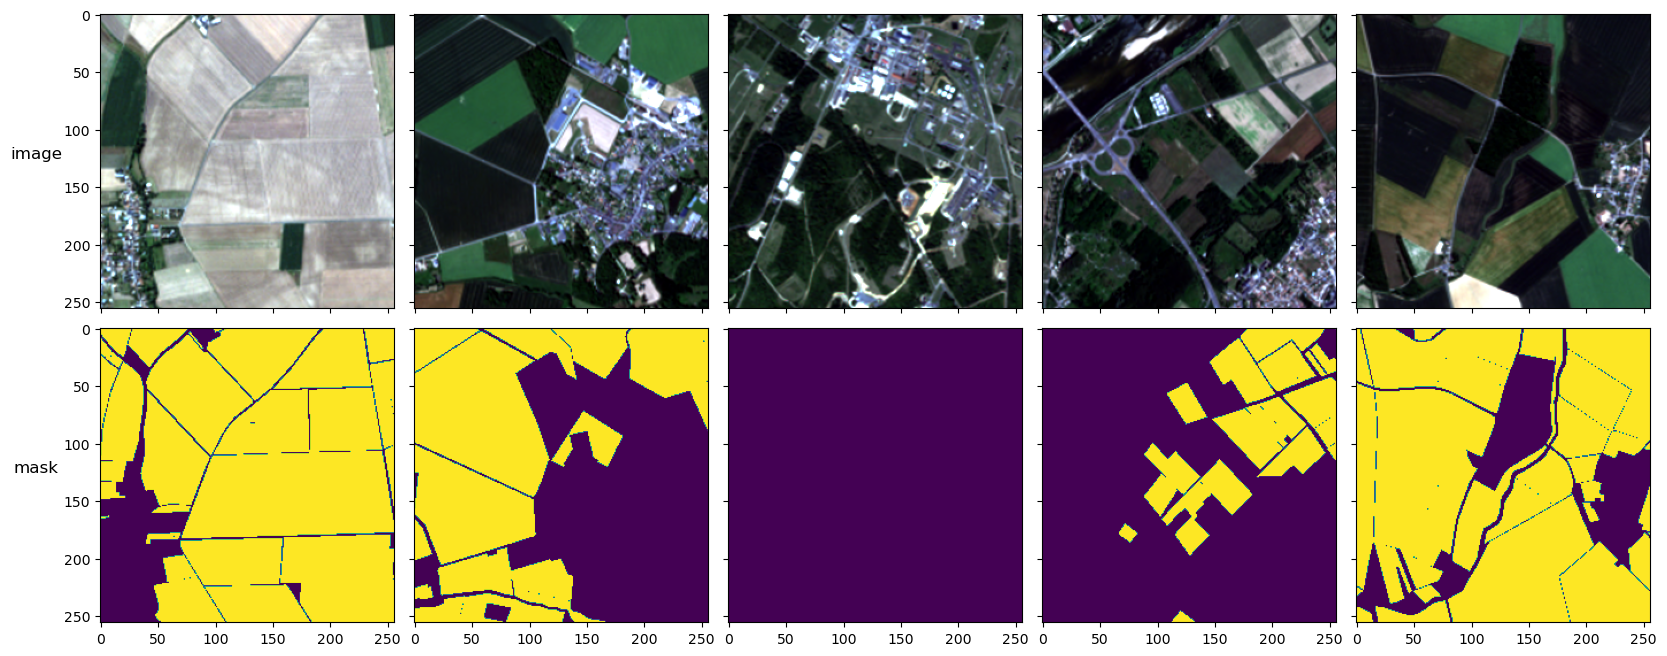

In [11]:
train_dataset, valid_dataset, test_dataset = get_datasets(paths['image'], 
                                                          paths['mask'], 
                                                          mask_band, 
                                                          min_max, 
                                                          data_augmentations)

train_dataloader, valid_dataloader, test_dataloader = get_loaders(train_dataset, 
                                                                  valid_dataset, 
                                                                  test_dataset, 
                                                                  batch_size, 
                                                                  n_cpu)

show_samples(train_dataloader, labels=labels, nb_samples = 5)


## Training

In [12]:
unet = smp.Unet('resnet50', encoder_weights='imagenet', classes=1, in_channels=4)


In [13]:
model = AdamWMultiStep(unet, loss, lr)
callbacks = get_callbacks()

In [14]:
model, trainer, logger = training_loop(model, 
                                       train_dataloader, 
                                       valid_dataloader, 
                                       project_name, 
                                       max_epochs, 
                                       hyperparameters, 
                                       callbacks)

# loading model again from best checkpoint
model = AdamWMultiStep.load_from_checkpoint(callbacks[1].best_model_path, model=unet, loss=loss, lr=lr)
validate_test(model, trainer, valid_dataloader, test_dataloader)
send_images(model, logger, test_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: quentin-yeche (quentin-yeche-phd). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 32.5 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.097   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]